In [1]:
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, chi2_contingency
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus
from catboost import CatBoostClassifier, cv, Pool

/Users/gergelybognar/.local/share/virtualenvs/titanic-Y95FCt4K/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# Data source: https://www.kaggle.com/c/titanic/data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [3]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
df_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


# Exploratory Data Analysis / Feature Engineering

## Women and children first

For the next section it worths understanding the quote "Women and children first".

The phrase was popularised by its usage on the RMS Titanic. The Second Officer suggested to Captain Smith, "Hadn't we better get the women and children into the boats, sir?", to which the captain responded: "put the women and children in and lower away". The First (Officer Murdoch) and Second (Officer Lightoller) officers interpreted the evacuation order differently; Murdoch took it to mean women and children first, while Lightoller took it to mean women and children only. Second Officer Lightoller lowered lifeboats with empty seats if there were no women and children waiting to board, while First Officer Murdoch allowed a limited number of men to board if all the nearby women and children had embarked.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Women_and_children_first)

## Helper Functions

In [5]:
def explore_binary(series):
    print("Ratio: {}".format(series.mean()))

    
def dependency_categorical(feature, label, binned=False, sort_index=False):
    """ Makes a crosstabulation between categorical feature and label """
    # Calculate crosstab and counts
    df_crosstab = pd.crosstab(feature, label)
    counts = df_crosstab.sum(axis=1)
    df_crosstab_normed = df_crosstab.divide(counts, axis=0)
    df_crosstab_normed["Count"] = counts
    # Sorting
    if binned:
        df_crosstab_normed["Bin_left"] = [x.left for x in df_crosstab_normed.index.values]
        df_crosstab_normed = df_crosstab_normed.sort_values("Bin_left")
        df_crosstab_normed = df_crosstab_normed.drop("Bin_left", axis=1)
    else:
        if sort_index:
            df_crosstab_normed = df_crosstab_normed.sort_index()
        else:
            df_crosstab_normed = df_crosstab_normed.sort_values("Count", ascending=False)
    # Printing
    print(df_crosstab_normed)
    # Chi-square test of independence
    frequencies = np.array([df_crosstab[0].values, df_crosstab[1].values])
    chi2, p_val, dof, expected = chi2_contingency(frequencies)
    print("")
    print("Chi2 value: {} p value: {}".format(chi2, p_val))

    
def controlled_dependency_categorical(df, controlled_feature_name, feature_name, binned=False, sort_index=False):
    for controlled_level in np.sort(df[controlled_feature_name].unique()):
        level_mask = df[controlled_feature_name] == controlled_level
        df_level = df[level_mask]
        print("")
        print("{} = {}".format(controlled_feature_name, controlled_level))
        dependency_categorical(df_level[feature_name], df_level[label_name], binned, sort_index)
    

def dependency_numerical_small(df, feature_name):
    df_groupped = df.groupby(feature_name).agg({
        label_name: {"Sum": "sum", "Count": "count"},
    })
    df_groupped["Count"] = df_groupped[(label_name, "Count")]
    df_groupped["Survival_ratio"] = df_groupped[(label_name, "Sum")] / df_groupped[(label_name, "Count")]
    df_groupped = df_groupped.drop(label_name, axis=1)
    print(df_groupped)

    
def dependency_numerical(df, feature_name, label_name):
    df_pairplot = df[[feature_name, label_name]].dropna()
    feature_negative = df_pairplot[df_pairplot[label_name] == 0][feature_name]
    feature_positive = df_pairplot[df_pairplot[label_name] == 1][feature_name]
    # Distribution plots
    sns.distplot(feature_negative, kde=True, label="Perished")
    sns.distplot(feature_positive, kde=True, label="Survived")
    plt.legend()
    plt.show()
    # Describe
    print("Describe {}".format(feature_name))
    print(df[feature_name].describe(percentiles=np.linspace(0.1, 0.9, 9)))
    # Kolmogorov–Smirnov test
    d_val, p_val = ks_2samp(feature_negative, feature_positive)
    print("")
    print("Two sample Kolmogorov–Smirnov test for {}".format(feature_name))
    print("D value: {} p value: {}".format(d_val, p_val))

# This column will help count rows after groupby
df_train["Count"] = 1

## Label

In [6]:
label_name = "Survived"

print("Survived")
explore_binary(df_train[label_name])

Survived
Ratio: 0.3838383838383838


There is no huge imbalance in the labels.

## Missing Values

Ratio of missing values of columns:
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
Count          0.000000
dtype: float64


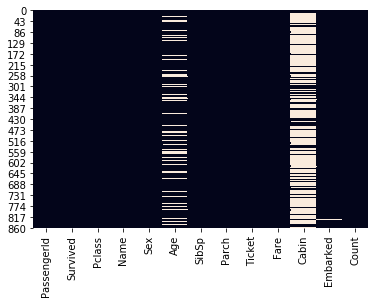

Ratio of missing values of columns:
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64


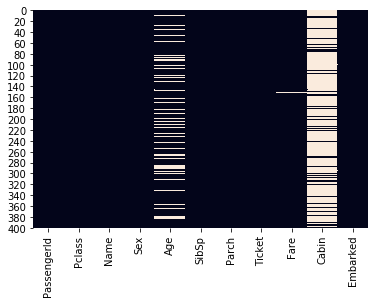

In [7]:
def inspect_missing(df):
    dataset_size = df.shape[0]
    print("Ratio of missing values of columns:")
    print(df.isnull().sum() / dataset_size)
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()

inspect_missing(df_train)

inspect_missing(df_test)

* Age has a considerable amount of missing values (20% in training set)
* Cabin has a lot of missing values (77% in training set)
* Embarked has a small amount of missing values (0.22%) in training set
* Fare has a small amount of missing values (0.24%) in test set
* The distribution of missing values is even

We can add new features to signal if cabin or age is missing, maybe this is correlating with the target variable

In [8]:
df_train["CabinMissing"] = df_train["Cabin"].isna()
df_train["AgeMissing"] = df_train["Age"].isna()

In [9]:
dependency_categorical(df_train["CabinMissing"], df_train[label_name])

Survived             0         1  Count
CabinMissing                           
True          0.700146  0.299854    687
False         0.333333  0.666667    204

Chi2 value: 87.94148561238097 p value: 6.7419704360811776e-21


In [10]:
dependency_categorical(df_train["AgeMissing"], df_train[label_name])

Survived           0         1  Count
AgeMissing                           
False       0.593838  0.406162    714
True        0.706215  0.293785    177

Chi2 value: 7.10597508442256 p value: 0.007682742096212262


The missing values of `Cabin` and `Age` explain a lot of variance.

## Pclass

In [11]:
dependency_categorical(df_train["Pclass"], df_train[label_name])

Survived         0         1  Count
Pclass                             
3         0.757637  0.242363    491
1         0.370370  0.629630    216
2         0.527174  0.472826    184

Chi2 value: 102.88898875696056 p value: 4.549251711298793e-23


* The third class tickets are in majority
* The higher the class number, the lower the survival ratio

## Sex

In [12]:
dependency_categorical(df_train["Sex"], df_train[label_name])

Survived         0         1  Count
Sex                                
male      0.811092  0.188908    577
female    0.257962  0.742038    314

Chi2 value: 260.71702016732104 p value: 1.1973570627755645e-58


* The majority of pessengers are males
* The survival ratio of females (74%) is significantly higher than of males (19%)

## Embarked

In [13]:
dependency_categorical(df_train["Embarked"], df_train[label_name])

Survived         0         1  Count
Embarked                           
S         0.663043  0.336957    644
C         0.446429  0.553571    168
Q         0.610390  0.389610     77

Chi2 value: 26.48914983923762 p value: 1.769922284120912e-06


Passengers were boarding the Titanic from 3 different cities in Europe, before heading off to New York: Southampton (England) encoded as `S`, Cherbourg (France) encoded as `C` and Queenstown (Ireland) encoded as `Q`.

* Most of the passengers embarked in Southampton
* The port of embarkation explains some variance
    * Does the port really matter?
    * Does this feature only correlate to other features, that cause this effect?
    * Does the port contain some information that can't be explained by the other features?
    * We will have to answer these questions later

## Age

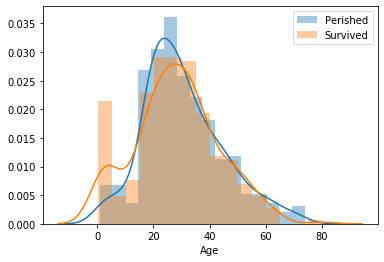

Describe Age
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
10%       14.000000
20%       19.000000
30%       22.000000
40%       25.000000
50%       28.000000
60%       31.800000
70%       36.000000
80%       41.000000
90%       50.000000
max       80.000000
Name: Age, dtype: float64

Two sample Kolmogorov–Smirnov test for Age
D value: 0.08877683799609629 p value: 0.12277292350653957


In [14]:
dependency_numerical(df_train, "Age", label_name)

Let's bin age and investigate what is the survival rate in each bin.

In [15]:
df_train["AgeBinnedExplore"] = pd.cut(df_train["Age"], 20)
dependency_categorical(df_train["AgeBinnedExplore"], df_train[label_name], binned=True)

Survived                 0         1  Count
AgeBinnedExplore                           
(0.34, 4.399]     0.325000  0.675000     40
(4.399, 8.378]    0.357143  0.642857     14
(8.378, 12.357]   0.733333  0.266667     15
(12.357, 16.336]  0.516129  0.483871     31
(16.336, 20.315]  0.658228  0.341772     79
(20.315, 24.294]  0.632653  0.367347     98
(24.294, 28.273]  0.647059  0.352941     85
(28.273, 32.252]  0.583333  0.416667     84
(32.252, 36.231]  0.520548  0.479452     73
(36.231, 40.21]   0.622222  0.377778     45
(40.21, 44.189]   0.657143  0.342857     35
(44.189, 48.168]  0.657143  0.342857     35
(48.168, 52.147]  0.517241  0.482759     29
(52.147, 56.126]  0.562500  0.437500     16
(56.126, 60.105]  0.615385  0.384615     13
(60.105, 64.084]  0.636364  0.363636     11
(64.084, 68.063]  1.000000  0.000000      4
(68.063, 72.042]  1.000000  0.000000      5
(72.042, 76.021]  1.000000  0.000000      1
(76.021, 80.0]    0.000000  1.000000      1

Chi2 value: 32.34980578915267 p

* Age explains some variance
* Children (from 0 to 16 years old) have higher survival rate

In [16]:
print(df_train[df_train["Age"] < 1]["Age"].tolist())

[0.83, 0.92, 0.75, 0.75, 0.67, 0.42, 0.83]


Age has a few fraction numbers in it, like 0.42, 0.67. Maybe they are mistypes of and actually mean 42 and 67, or they are indeed infants with age below 1 years.

In [17]:
print((df_train[df_train["Age"] < 1]["Age"]*12).tolist())

[9.959999999999999, 11.040000000000001, 9.0, 9.0, 8.040000000000001, 5.04, 9.959999999999999]


If we multiply the fraction mnumbers with 12 (number of months in a year) then we get to numbers very close to integers, meaning these age numbers could be calculated from months of the infants. So probably these are correct values, I will leave them as they are.

## SibSp

In [18]:
dependency_categorical(df_train["SibSp"], df_train[label_name], sort_index=True)

Survived         0         1  Count
SibSp                              
0         0.654605  0.345395    608
1         0.464115  0.535885    209
2         0.535714  0.464286     28
3         0.750000  0.250000     16
4         0.833333  0.166667     18
5         1.000000  0.000000      5
8         1.000000  0.000000      7

Chi2 value: 37.27179291520431 p value: 1.5585810465902116e-06


## Parch

In [19]:
dependency_categorical(df_train["Parch"], df_train[label_name], sort_index=True)

Survived         0         1  Count
Parch                              
0         0.656342  0.343658    678
1         0.449153  0.550847    118
2         0.500000  0.500000     80
3         0.400000  0.600000      5
4         1.000000  0.000000      4
5         0.800000  0.200000      5
6         1.000000  0.000000      1

Chi2 value: 27.925784060236168 p value: 9.703526421039997e-05


## Family size

A lot of Kagglers hypothise that the size of the family on board (sum of SibSp (siblings, spouses) and Parch (parents, children) is a better predictior than the two features separatly. It can also ease iterpretibility, so I add this feature.

In [20]:
df_train["FamilySize"] = df_train["SibSp"] + df_train["Parch"]

dependency_categorical(df_train["FamilySize"], df_train[label_name], sort_index=True)

Survived           0         1  Count
FamilySize                           
0           0.696462  0.303538    537
1           0.447205  0.552795    161
2           0.421569  0.578431    102
3           0.275862  0.724138     29
4           0.800000  0.200000     15
5           0.863636  0.136364     22
6           0.666667  0.333333     12
7           1.000000  0.000000      6
10          1.000000  0.000000      7

Chi2 value: 80.67231343783078 p value: 3.579668975443533e-14


Majority of the passengers are travelling solo. It seems like solo travellers have lower chance of survival. Though it possible, that there is no causal relationship between family size and survival, but family size only correlates with other features that cause this effect, like Age and Sex.

## Ticket

Multiple pessengers can travel with the same ticket number. It means that they bought the ticket together. I calculate how many passengers belong to one ticket number as a new column:

In [21]:
df_pessenger_per_ticket = (
    df_train
    .groupby("Ticket")
    .agg({"Count": "count"})
    .reset_index()
    .rename({"Count": "PassengerPerTicket"}, axis=1)
)
df_train = df_train.merge(df_pessenger_per_ticket, on="Ticket", how="left")

In [22]:
dependency_numerical_small(df_train, "PassengerPerTicket")

                   Count Survival_ratio
                                       
PassengerPerTicket                     
1                    547       0.297989
2                    188       0.574468
3                     63       0.698413
4                     44       0.500000
5                     10       0.000000
6                     18       0.000000
7                     21       0.238095


/Users/gergelybognar/.local/share/virtualenvs/titanic-Y95FCt4K/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


Passenger per ticket should correlate to the family size, assuming families buy their tickets together:

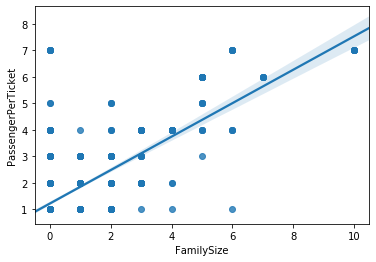

           PassengerPerTicket                
                         Mean       Std Count
FamilySize                                   
0                    1.281192  0.896240   537
1                    1.745342  0.644976   161
2                    2.147059  0.916267   102
3                    2.931034  0.961065    29
4                    3.533333  0.990430    15
5                    5.272727  0.935125    22
6                    5.500000  2.022600    12
7                    6.000000  0.000000     6
10                   7.000000  0.000000     7

Correlation coefficient: 0.7484868255384143 p-value: 9.235712550062326e-161


In [23]:
# Regplot
sns.regplot(df_train["FamilySize"], df_train["PassengerPerTicket"])
plt.show()

# Groupby perssenger per ticket, aggregate family size
print(df_train.groupby("FamilySize").agg({"PassengerPerTicket": {"Mean": "mean", "Std": "std", "Count": "count"}}))

# Correlation coefficient
print("")
print("Correlation coefficient: {} p-value: {}".format(
    *pearsonr(df_train["FamilySize"], df_train["PassengerPerTicket"])
))

* There is a strong correlation between family size and passenger per ticket
* Our new `PassengerPerTicket` feature looks valid

## Fare

Fare is calculated per ticket, not per person. So I normalize fare with the number of passengers belonging to the same ticket:

In [24]:
df_train["FarePerPerson"] = df_train["Fare"] / df_train["PassengerPerTicket"]

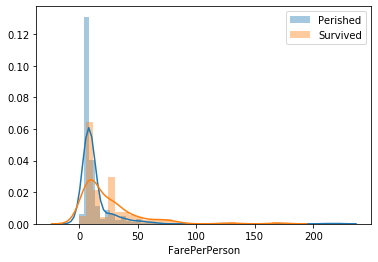

Describe FarePerPerson
count    891.000000
mean      17.788989
std       21.218157
min        0.000000
10%        7.050000
20%        7.733300
30%        7.854200
40%        8.050000
50%        8.850000
60%       11.725000
70%       14.500000
80%       26.550000
90%       39.400000
max      221.779200
Name: FarePerPerson, dtype: float64

Two sample Kolmogorov–Smirnov test for FarePerPerson
D value: 0.31310516728980925 p value: 2.6645352591003757e-15


In [25]:
dependency_numerical(df_train, "FarePerPerson", label_name)

In [26]:
df_train["FarePerPersonBinned"] = pd.qcut(df_train["FarePerPerson"], 5)
dependency_categorical(df_train["FarePerPersonBinned"], df_train[label_name], binned=True)

Survived                    0         1  Count
FarePerPersonBinned                           
(-0.001, 7.733]      0.783333  0.216667    180
(7.733, 8.05]        0.743119  0.256881    218
(8.05, 11.725]       0.659420  0.340580    138
(11.725, 26.55]      0.513228  0.486772    189
(26.55, 221.779]     0.349398  0.650602    166

Chi2 value: 95.63361363838052 p value: 8.355915208716143e-20


The higher the fare per person, the higher the survival rate.

## Name

In [27]:
df_train["Name"].head(20).tolist()

['Braund, Mr. Owen Harris',
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
 'Heikkinen, Miss. Laina',
 'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
 'Allen, Mr. William Henry',
 'Moran, Mr. James',
 'McCarthy, Mr. Timothy J',
 'Palsson, Master. Gosta Leonard',
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
 'Nasser, Mrs. Nicholas (Adele Achem)',
 'Sandstrom, Miss. Marguerite Rut',
 'Bonnell, Miss. Elizabeth',
 'Saundercock, Mr. William Henry',
 'Andersson, Mr. Anders Johan',
 'Vestrom, Miss. Hulda Amanda Adolfina',
 'Hewlett, Mrs. (Mary D Kingcome) ',
 'Rice, Master. Eugene',
 'Williams, Mr. Charles Eugene',
 'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
 'Masselmani, Mrs. Fatima']

### Title

A lot of Kagglers are extracting the title info from the name. It can signal if a woman is married or not, or if a person had a noble rank. It seems like a good idea, so I will do the same:

In [28]:
def get_titles(name):
    title = None
    if name:
        match = re.search("\s([A-Za-z]+)\.", name)
        if match:
            title = match.group(1)
    return title

df_train["Title"] = df_train["Name"].apply(get_titles)

In [29]:
print(df_train["Title"].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


In [30]:
dependency_categorical(df_train["Title"], df_train[label_name])

Survived         0         1  Count
Title                              
Mr        0.843327  0.156673    517
Miss      0.302198  0.697802    182
Mrs       0.208000  0.792000    125
Master    0.425000  0.575000     40
Dr        0.571429  0.428571      7
Rev       1.000000  0.000000      6
Major     0.500000  0.500000      2
Col       0.500000  0.500000      2
Mlle      0.000000  1.000000      2
Mme       0.000000  1.000000      1
Ms        0.000000  1.000000      1
Capt      1.000000  0.000000      1
Lady      0.000000  1.000000      1
Jonkheer  1.000000  0.000000      1
Don       1.000000  0.000000      1
Countess  0.000000  1.000000      1
Sir       0.000000  1.000000      1

Chi2 value: 300.02302134972405 p value: 2.522768232466142e-54


* `Mrs` (married women) have higher chance of surviving than `Miss` (not married women).
* Some other titles also explain variation, like `Master`, `Dr` and `Rev`, but the count of these titles in the training data very is small.

Hence I create a new feature which keeps the most frequent titles (`Mr`, `Miss`, `Mrs`) and groups the rare titles to `Other`: 

In [31]:
def get_title_reduced(title):
    if title in ("Mr", "Miss", "Mrs"):
        return title
    else:
        return "Other"
        

df_train["TitleReduced"] = df_train["Title"].apply(get_title_reduced)


dependency_categorical(df_train["TitleReduced"], df_train[label_name])

Survived             0         1  Count
TitleReduced                           
Mr            0.843327  0.156673    517
Miss          0.302198  0.697802    182
Mrs           0.208000  0.792000    125
Other         0.477612  0.522388     67

Chi2 value: 282.14980191288873 p value: 7.255378086876214e-61


### IsEnglish

[Some sources](https://www.independent.co.uk/voices/did-the-third-class-passengers-on-the-titanic-have-a-fair-chance-1155678.html) state that "many of the emigrants in third class died because their poor English meant they did not understand what was happening". It might be true, so I create a new feature called `IsEnglish`, that is an estimate if the passenger was english speaking or not, based on the `Name`.

In [32]:
with open("data/english_names.txt") as file:
    english_names = set([x.strip() for x in file.readlines()])

def get_is_english(name):
    stripped_name = "".join(x for x in name if (x.isalpha() or x == " "))
    words_in_name = set(stripped_name.split())
    if english_names.intersection(words_in_name):
        return True
    return False

df_train["IsEnglish"] = df_train["Name"].apply(get_is_english)

dependency_categorical(df_train["IsEnglish"], df_train[label_name])

Survived          0         1  Count
IsEnglish                           
True       0.577598  0.422402    741
False      0.806667  0.193333    150

Chi2 value: 26.717029016009196 p value: 2.3553656556357187e-07


## Cabin

Though the cabin info has low availibility it can contain valuable information. The letter in the cabin represents the deck, A is at the top of the ship, G is at the bottom. We can hypotize that it was harder to escape from the lower decks (at least in the movie it was like that). And the number can indicate the position of the cabin on the ship. So I will exctract the deck and number as new features. There are cases when there are multiple cabins listed in the same cell, then will chose the majority of decks and average of numbers.

Info from: [Titanic Deskmap](https://www.encyclopedia-titanica.org/titanic-deckplans/)

In [33]:
def get_deck_number(cabin, is_deck):
    if pd.isna(cabin):
        return None
    
    cabin = cabin.replace("F", "")
    matches = re.findall("([a-zA-Z])(\d*)", cabin)

    
    numbers = np.array([int(x[1]) for x in matches if x[1]])
    
    # Calculate cabin deck
    if is_deck:
        decks = np.array([x[0] for x in matches if x[0]])
        if len(decks) > 0:
            # Most frequent deck
            values, counts = np.unique(decks,return_counts=True)
            return values[np.argmax(counts)]
        else:
            return None

    # Calculate cabin number
    else:
        if len(numbers) > 0:
            return numbers.mean()
        else:
            return None

        
df_train["CabinDeck"] = df_train["Cabin"].apply(get_deck_number, is_deck=True)
df_train["CabinNumber"] = df_train["Cabin"].apply(get_deck_number, is_deck=False)

In [34]:
dependency_categorical(df_train["CabinDeck"], df_train[label_name], sort_index=True)

Survived          0         1  Count
CabinDeck                           
A          0.533333  0.466667     15
B          0.255319  0.744681     47
C          0.406780  0.593220     59
D          0.242424  0.757576     33
E          0.242424  0.757576     33
G          0.714286  0.285714      7
T          1.000000  0.000000      1

Chi2 value: 14.313921402762837 p value: 0.026319452453884597


* Deck explains some variance
* The dependency is not according to our intuition

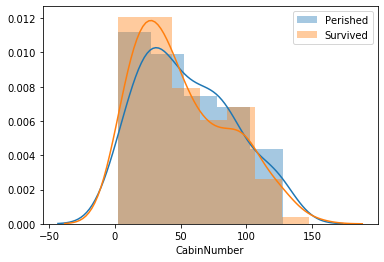

Describe CabinNumber
count    191.000000
mean      52.264398
std       35.248723
min        2.000000
10%       10.000000
20%       20.000000
30%       26.000000
40%       35.000000
50%       46.000000
60%       54.000000
70%       70.000000
80%       86.000000
90%      101.000000
max      148.000000
Name: CabinNumber, dtype: float64

Two sample Kolmogorov–Smirnov test for CabinNumber
D value: 0.09092027559055119 p value: 0.8297270717524061


In [35]:
dependency_numerical(df_train, "CabinNumber", label_name)

The cabin number seems to have no effect on the survival rate

## Correlations

### Correlation matrix including dependent and the main features

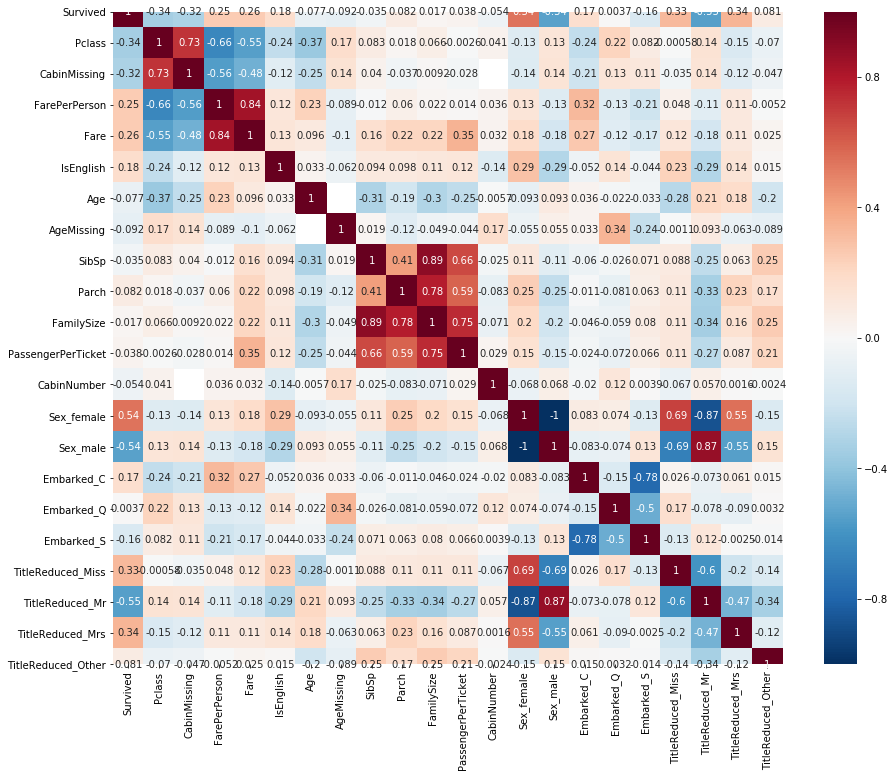

In [36]:
corr_train = (
    df_train[[
    "Survived",
    "Pclass", "CabinMissing", "FarePerPerson", "Fare",
    "IsEnglish",
    "Age",
    "AgeMissing",
    "SibSp", "Parch", "FamilySize", "PassengerPerTicket",
    "CabinNumber"]]
    .join(pd.get_dummies(df_train[["Sex", "Embarked", "TitleReduced"]]))
    .corr()
)

plt.figure(figsize=(15, 12))
sns.heatmap(corr_train, annot=True, cmap="RdBu_r")
plt.show()

* `CabinMissing` is highly correlated with `Pclass` and `FarePerPerson`
    * This could explain, why passengers with `CabinMissing` have higher survival rate
* `SibSp`, `Pcharch`, `FamilySize` and `PassengerPerTicket` have strong correlation with each other, not surprisingly
* `Sex` correlates with titles in name
* `Embarked` at `C` (Cherbourg) has a positive correlation with `FarePerPerson` and negative correlation with `Pclass`
    * This could explain why passengers embarked at `C` have higher survival rate

### Correlation matrix including dependent and the rest of the features

If I would include `Title` and `CabinDeck` in the former correlation matrix, it would be too big and unreadable. So I create a second matrix for them. I also correlate these featured with `Pclass` and `FarePerPerson`.

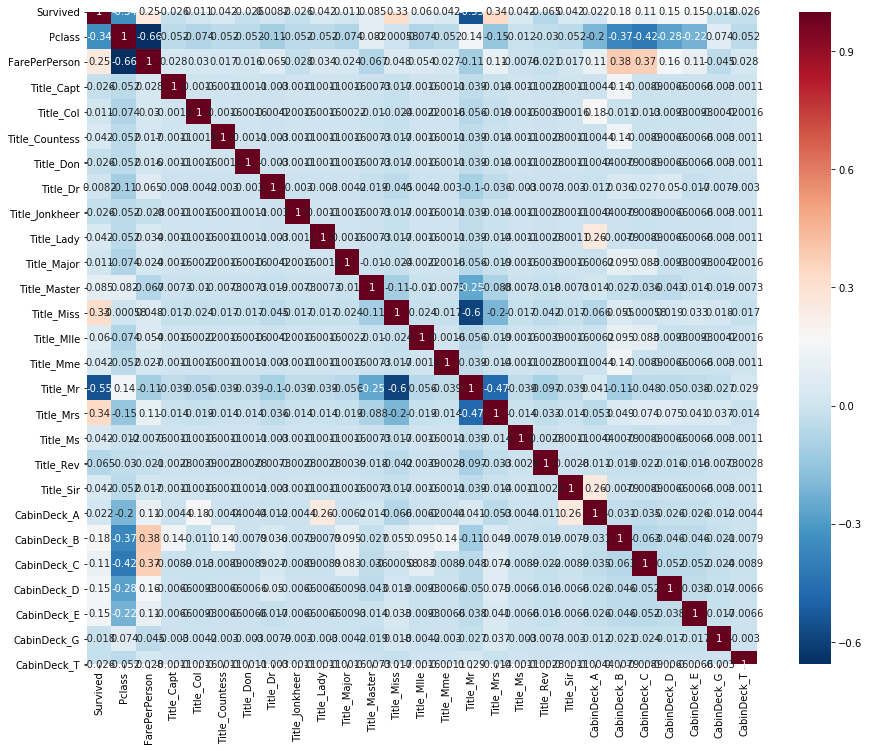

In [37]:
corr_train_other = (
    df_train[["Survived", "Pclass", "FarePerPerson"]]
    .join(pd.get_dummies(df_train[["Title", "CabinDeck",]]))
    .corr()
)

plt.figure(figsize=(15, 12))
sns.heatmap(corr_train_other, annot=True, cmap="RdBu_r")
plt.show()

## CabinMissing and Pclass

In [38]:
pd.crosstab(df_train["Pclass"], df_train["CabinMissing"])

CabinMissing,False,True
Pclass,,
1,176,40
2,16,168
3,12,479


* Cabin is missing for majority of second and third class tickets
* Cabin is not missing for majority of the first class tickets

In [39]:
controlled_dependency_categorical(df_train, "Pclass", "CabinMissing")


Pclass = 1
Survived             0         1  Count
CabinMissing                           
False         0.335227  0.664773    176
True          0.525000  0.475000     40

Chi2 value: 4.252545120320858 p value: 0.03919155354419599

Pclass = 2
Survived             0         1  Count
CabinMissing                           
True          0.559524  0.440476    168
False         0.187500  0.812500     16

Chi2 value: 6.687584288366373 p value: 0.009708667563575092

Pclass = 3
Survived             0         1  Count
CabinMissing                           
True          0.764092  0.235908    479
False         0.500000  0.500000     12

Chi2 value: 3.1245711134084364 p value: 0.07712016276288634


Even when controlled on `Pclass` Cabin not missing still leads to higher survival rate for second and third class tickets, though the number or datapoints is low in such cases.

## Embarked and Sex and Pclass

In [40]:
pd.crosstab(df_train["Pclass"], df_train["Embarked"], normalize="columns")

Embarked,C,Q,S
Pclass,,,
1,0.505952,0.025974,0.197205
2,0.101190,0.038961,0.254658
3,0.392857,0.935065,0.548137


In [41]:
print("Males")
df_male = df_train[df_train["Sex"] == "male"]
controlled_dependency_categorical(df_male, "Pclass", "Embarked")

print("")
print("------------------------------")
print("Females")
df_male = df_train[df_train["Sex"] == "female"]
controlled_dependency_categorical(df_male, "Pclass", "Embarked")

Males

Pclass = 1
Survived         0         1  Count
Embarked                           
S         0.645570  0.354430     79
C         0.595238  0.404762     42
Q         1.000000  0.000000      1

Chi2 value: 0.8876377657571148 p value: 0.6415816117196076

Pclass = 2
Survived         0         1  Count
Embarked                           
S         0.845361  0.154639     97
C         0.800000  0.200000     10
Q         1.000000  0.000000      1

Chi2 value: 0.329198515250668 p value: 0.8482335591169639

Pclass = 3
Survived         0         1  Count
Embarked                           
S         0.871698  0.128302    265
C         0.767442  0.232558     43
Q         0.923077  0.076923     39

Chi2 value: 4.71918345327616 p value: 0.09445878032864939

------------------------------
Females

Pclass = 1
Survived         0         1  Count
Embarked                           
S         0.041667  0.958333     48
C         0.023256  0.976744     43
Q         0.000000  1.000000      1

Chi2 va

After controlled on `Sex` and `Pclass`, `Embarked` still explains some variance
* For males with third class tickets, passengers embarked in Queenstown have the lowest survival rate
* For females with third class tickets, passengers embarked in Southampton have the lowest survival rate

## IsEnglish and Sex and Pclass

In [42]:
print("Males")
df_male = df_train[df_train["Sex"] == "male"]
controlled_dependency_categorical(df_male, "Pclass", "IsEnglish")

print("")
print("------------------------------")
print("Females")
df_male = df_train[df_train["Sex"] == "female"]
controlled_dependency_categorical(df_male, "Pclass", "IsEnglish")

Males

Pclass = 1
Survived          0         1  Count
IsEnglish                           
True       0.660550  0.339450    109
False      0.384615  0.615385     13

Chi2 value: 2.7059179352757328 p value: 0.09997652228508273

Pclass = 2
Survived          0         1  Count
IsEnglish                           
True       0.851485  0.148515    101
False      0.714286  0.285714      7

Chi2 value: 0.18257904837487168 p value: 0.6691661518355887

Pclass = 3
Survived          0         1  Count
IsEnglish                           
True       0.852018  0.147982    223
False      0.887097  0.112903    124

Chi2 value: 0.5646188513931502 p value: 0.4524052003882283

------------------------------
Females

Pclass = 1
Survived          0         1  Count
IsEnglish                           
True       0.032258  0.967742     93
False      0.000000  1.000000      1

Chi2 value: 7.167828587183427 p value: 0.007422256245714153

Pclass = 2
Survived      0     1  Count
IsEnglish                   
T

* If we only look at the `IsEnglish` feature, then it looks like that english speaking passengers have higher survival ratio
* But if we control on `Sex` and `Pclass` this difference seems to disapper
* We will only know if we test the model performace with both including and excluding the feature `IsEnglish`

# Modelling

## Iterpretable Model - Decision Tree

In [43]:
# Select exploratory features
feature_names = [
    "Pclass", "FarePerPerson",
    "SibSp", "Parch", "FamilySize", "PassengerPerTicket",
    "Sex", "Age",
    "TitleReduced", "IsEnglish",
    "Embarked",
    "CabinMissing", "AgeMissing",
]
features_train = df_train[feature_names]
labels_train = df_train[label_name]


# Encode categorical values to numbers
categorical_feature_maps = [
    ("Sex", {"female": 0, "male": 1}),
    ("Embarked", {"S": 0, "Q": 1, "C": 2}), #Mean encoding
    ("TitleReduced", {"Mr": 0, "Other": 1, "Miss": 2, "Mrs": 3}), #Mean encoding
]
for feature_name, feature_map in categorical_feature_maps:
    features_train[feature_name] = features_train[feature_name].map(feature_map)

# Fill nulls
features_train["Embarked"] = features_train["Embarked"].fillna(features_train["Embarked"].mode().iloc[0])
features_train["Age"] = features_train["Age"].fillna(features_train["Age"].mean())

/Users/gergelybognar/.local/share/virtualenvs/titanic-Y95FCt4K/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gergelybognar/.local/share/virtualenvs/titanic-Y95FCt4K/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gergelybognar/.local/share/virtualenvs/titanic-Y95FCt4K/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [44]:
base_model = DecisionTreeClassifier()

parameters = {
    "min_samples_leaf": [15, 20, 25, 30, 35, 40, 50, 70, 100],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15],
    "criterion": ("gini", "entropy"),
}

grid_searcher = GridSearchCV(base_model, parameters, cv=10)
grid_searcher.fit(features_train, labels_train)

model = grid_searcher.best_estimator_

print("Best CV score: {}".format(grid_searcher.best_score_))
print("")
print(model)


Best CV score: 0.8170594837261503

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


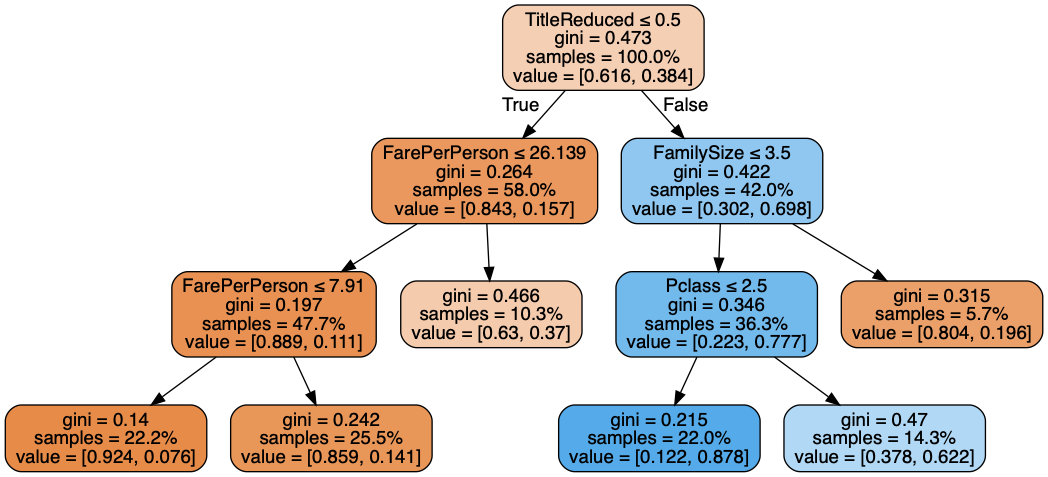

In [45]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=feature_names,
                proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Accurate Model - Gradient Boosting

### Select features

In [46]:
feature_names_cb = [
    "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", 
    "Embarked", "CabinMissing", "AgeMissing", "FamilySize",
    "PassengerPerTicket", "FarePerPerson", "Title", "TitleReduced",
    "CabinDeck", "CabinNumber", "IsEnglish",
]


features_train_bc = df_train[feature_names_cb]
labels_train_bc = df_train[label_name]

cat_feature_names = [
    "Pclass", "Sex", "Embarked", "CabinMissing", "AgeMissing", 
     "Title", "TitleReduced", "CabinDeck", "IsEnglish",
]
cat_feature_indeces = [feature_names_cb.index(x) for x in cat_feature_names]

for cat_feature_name in cat_feature_names:
    features_train_bc[cat_feature_name] = features_train_bc[cat_feature_name].fillna("Unknown")

    
pool_train = Pool(data=features_train_bc,
                  label=labels_train_bc,
                  cat_features=cat_feature_indeces)

/Users/gergelybognar/.local/share/virtualenvs/titanic-Y95FCt4K/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Cross-validation

In [47]:
params = {"iterations": 1000,
          "loss_function": "Logloss",
          'custom_loss': 'Accuracy',
          "verbose": False}

scores = cv(pool_train,
            params,
            fold_count=10, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [48]:
best_accuraccy = scores["test-Accuracy-mean"].max()
best_iteration_number = scores[scores["test-Accuracy-mean"] == best_accuraccy]["iterations"].iloc[0]

print("Best iteration number: {}".format(best_iteration_number))
print("Best CV accuracy score: {}".format(best_accuraccy))

Best iteration number: 133
Best CV accuracy score: 0.8305320054477358


### Retrain

As a small sanity check I make a classical train test split with the selected model complexity.

In [49]:
features_train_bc_tt, features_test_bc_tt, labels_train_bc_tt, labels_test_bc_tt = train_test_split(features_train_bc, labels_train_bc, test_size=0.33)

model = CatBoostClassifier(iterations=best_iteration_number, cat_features=cat_feature_indeces)
model.fit(features_train_bc_tt, labels_train_bc_tt, verbose=False)

print("Train accuracy: {}".format(model.score(features_train_bc_tt, labels_train_bc_tt)))
print("Validation accuracy: {}".format(model.score(features_test_bc_tt, labels_test_bc_tt)))

Train accuracy: 0.8624161073825504
Validation accuracy: 0.8305084745762712


Then retrain on the whole available training set with the selected model complexity.

In [50]:
model = CatBoostClassifier(iterations=best_iteration_number)
model.fit(pool_train, verbose=False)